# Семинар по OpenCV | Домашнее задание 4

**Задачи:**

1. Ииспользуя перспективное преобразование, развернуть дорогу таким образом, чтобы она была непосредственно перед нами.

2. Создать "тень" для пальмы и отрисовать ее с ней на одном рисунке. 

**Данные:** изображения `../data/railway.jpeg`, `../data/palm.png`

---

Импорт библиотек:

In [1]:
import numpy as np
import cv2 as cv

import os
from typing import List, Tuple

import matplotlib.pyplot as plt

Игнорирование предупреждений:

In [2]:
import warnings

warnings.simplefilter('ignore')

Задание пути до папки с изображениями:

In [3]:
PATH = '../data/'

Задание функции, возвращающей получаемое по переданному пути изображение в формате RGB:

In [4]:
def plot_image(path: str, img_name: str) -> np.ndarray:
    img = os.path.join(path, img_name)

    img = cv.imread(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.show()

---

>**Задание 1**
>
>В папке находится изображение `railway.jpeg` с железной дорогой, уходящей вдаль от камеры. Необходимо, используя перспективное преобразование, развернуть дорогу таким образом, чтобы она была непосредственно перед нами.
>
>*Пример результата с подсказкой содержит изображение `railway_result.png`.* 
>
>*Подсказка: чтобы было легче определять координаты ключевых точек изображения, отобразите его с помощью `plt.imshow(img)` (!не в ноутбуке) - в правом нижнем углу открытого окна будут отображаться координаты пикселей, на которые Вы наводите мышкой.*

Выведение на экран изображения:

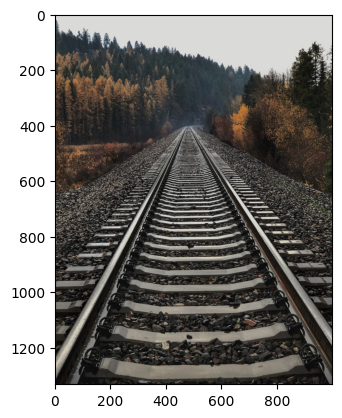

In [5]:
plot_image(PATH, 'railway.jpeg')

Выведение на экран образа результата:

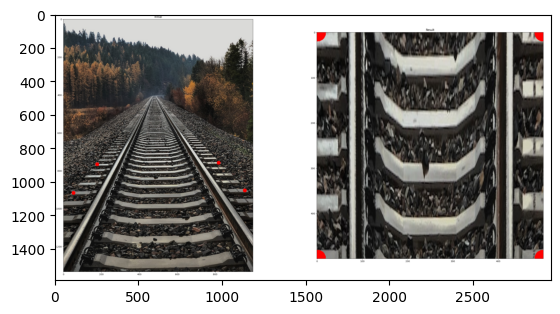

In [6]:
plot_image(PATH, 'railway_result.png')

---

Чтение изображения:

In [7]:
image_railway = cv.cvtColor(
    cv.imread(os.path.join(PATH, 'railway.jpeg')), 
    cv.COLOR_BGR2RGB
)

Установка библиотек:

In [8]:
%%capture no-display
!pip install PyQt5

Открытие изображения в новом окне для выбора четырёх точек по клику:

In [9]:
%matplotlib qt
import matplotlib.pyplot as plt

n_dots = 4

plt.title(f'Choose {n_dots} dots with a click in a window\n')
plt.imshow(image_railway)

points = plt.ginput(n_dots)
points = np.float32([[round(dot[0]), round(dot[1])] for dot in points])

print('Chosen dots coords:')
print(points)

plt.show()

if len(points) == n_dots:
    plt.close('all')

Chosen dots coords:
[[287. 639.]
 [ 99. 841.]
 [893. 820.]
 [709. 628.]]


Изменение формата вывода изображений: 

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

Задание функции трансформации изображения:

In [11]:
def transform_perspective(img: np.ndarray, points_1, points_2, rows_cols) -> np.ndarray:
    row, cols = rows_cols
    
    matrix = cv.getPerspectiveTransform(points_1, points_2)
    img_transform = cv.warpPerspective(img, matrix, (cols, rows))
    
    return img_transform

Выведение на экран изображения и его трансформированной части:

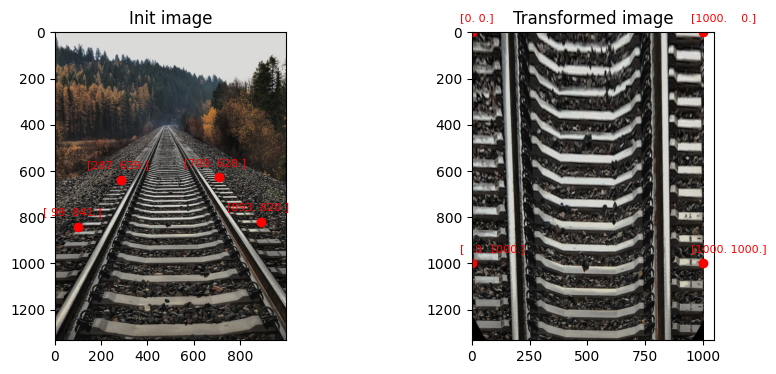

In [12]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.title('Init image')

plt.imshow(image_railway)

for dot in points:
    plt.text(dot[0] - 150, dot[1] - 50, dot, color='red', fontsize=8)
    plt.scatter(*dot, color='red')

plt.subplot(122)
plt.title('Transformed image')

rows, cols = image_railway.shape[:2]

points_transform = np.float32([[0, 0], [0, cols], [cols, cols], [cols, 0]])

image_railway_transform = transform_perspective(
    image_railway, 
    points_1=points,
    points_2=points_transform,
    rows_cols=(rows, cols)
)

plt.imshow(image_railway_transform)

for dot in (points_transform):
    plt.text(dot[0] - 50, dot[1] - 50, dot, color='red', fontsize=8)
    plt.scatter(*dot, color='red')

plt.show()

---

>**Задание 2**
>
>В папке находится изображение `palm.png` с пальмой. Используя классические аффинные преобразования, необходимо создать "тень" для этой пальмы и отрисовать ее с ней на одном рисунке. 
>
>*Пример результата находится в изображении `palm_result.png`.*

Выведение на экран изображения:

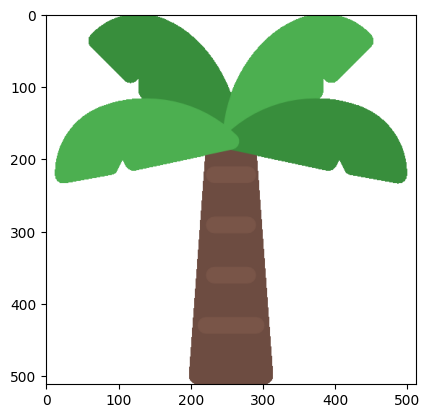

In [13]:
plot_image(PATH, 'palm.png')

Выведение на экран образа результата:

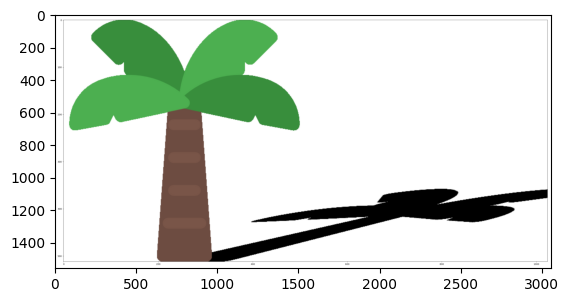

In [14]:
plot_image(PATH, 'palm_result.png')

---

Чтение изображения:

In [15]:
image_palm = cv.imread(os.path.join(PATH, 'palm.png'))

Задание функции очищения фона изображения:

>[OpenCV background removal](https://www.kaggle.com/code/vadbeg/opencv-background-removal)

In [16]:
def remove_background(img: np.ndarray, threshold: int) -> np.ndarray:
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, img_threshold = cv.threshold(img_gray, threshold, 255, cv.THRESH_BINARY_INV)

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
    morphed = cv.morphologyEx(img_threshold, cv.MORPH_CLOSE, kernel)

    contours = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    contour = sorted(contours, key=cv.contourArea)[-1]

    mask = cv.drawContours(img_threshold, contour, 0, (0, 255, 0), 0)
    img_mask = cv.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv.boundingRect(contour)
    img_black_background = img_mask[y:y+h, x:x+w]

    img_black_gray = cv.cvtColor(img_black_background, cv.COLOR_BGR2GRAY)
    
    _, alpha = cv.threshold(img_black_gray, 0, 255, cv.THRESH_BINARY)
    b, g, r = cv.split(img_black_background)

    rgba = [r, g, b, alpha]
    img_transparent = cv.merge(rgba, 4)

    return img_transparent

Очищение фона исходного изображения:

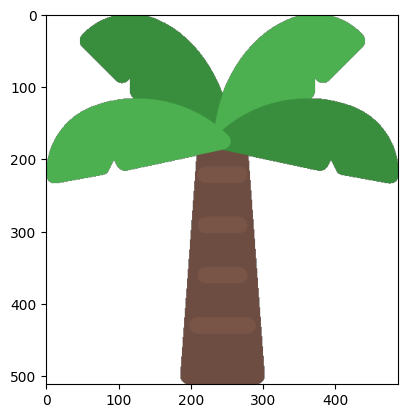

In [17]:
image_palm_transparent = remove_background(image_palm, 200)

plt.imshow(image_palm_transparent)
plt.show()

Задание функции конвертации изображения в чёрно-белый формат:

In [18]:
def convert_to_black(img: np.ndarray, threshold: int = 200) -> np.ndarray:
    img_black = cv.threshold(img, thresh=threshold, maxval=255, type=cv.THRESH_BINARY)[1]
    return img_black

Конвертация изображения в чёрно-белый формат:

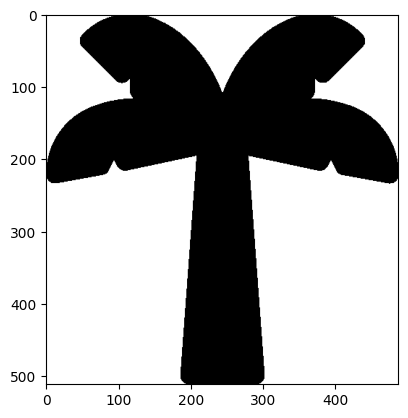

In [19]:
image_palm_black_transparent = convert_to_black(image_palm_transparent)

plt.imshow(image_palm_black_transparent)
plt.show()

Выведение на экран изображения и его тени:

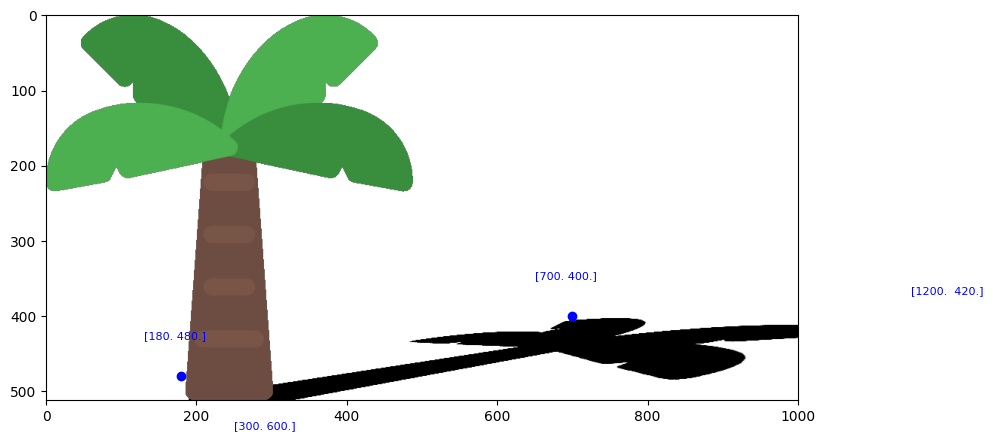

In [20]:
rows, cols = image_palm.shape[:2]
cols *= 2

points_init = np.float32([[0, 0], [500, 0], [0, 500], [500, 500]])
points_transform = np.float32([[700, 400], [1200, 420], [180, 480], [300, 600]])

image_palm_black_transform = transform_perspective(
    image_palm_black_transparent, 
    points_1=points_init,
    points_2=points_transform,
    rows_cols=(rows, cols)
)

plt.figure(figsize=(16, 5))

for dot in points_transform:
    plt.text(dot[0] - 50, dot[1] - 50, dot, color='blue', fontsize=8)
    plt.scatter(*dot, color='blue')

plt.imshow(image_palm_black_transform)
plt.imshow(image_palm_transparent)

plt.xlim(0, cols - cols % 1000)

plt.show()

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Семинар-по-OpenCV-|-Домашнее-задание-4" data-toc-modified-id="Наверх" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        Наверх ↑
    </a>
</div>